In [26]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from datetime import datetime
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [27]:
csv_path = '../Dataset/comments/cleaned_comments.csv'

output_path = '../Analyzer/output'
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jonathanjames/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonathanjames/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jonathanjames/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [28]:
# Function to clean text
def clean_text(text):
    if pd.isna(text):
        return ""
    
    # Convert to string if not already
    text = str(text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove Reddit formatting (e.g., *italic*, **bold**)
    text = re.sub(r'\*\*|\*', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    return text

# Modified tokenization approach to avoid punkt_tab dependency
def simple_tokenize(text):
    # Simple tokenization by splitting on whitespace
    return text.split()

In [29]:
# Load the CSV file
df = pd.read_csv(csv_path)

# Check for deleted comments
deleted_count = df[df['author'] == '[deleted]'].shape[0]

# Apply text cleaning to the 'body' column
df['cleaned_text'] = df['body'].apply(clean_text)

# Remove empty comments after cleaning
df = df[df['cleaned_text'].str.strip() != ""]
df['tokens'] = df['cleaned_text'].apply(simple_tokenize)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['tokens_without_stopwords'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Convert UTC timestamp to datetime
df['created_datetime'] = df['created_utc'].apply(lambda x: datetime.fromtimestamp(x))

# Sort by date
df = df.sort_values('created_datetime')

# Save the preprocessed data
preprocessed_path = f'{output_path}/preprocessed_comments.csv'

In [30]:
# Display basic information about the dataset
print(f"Total number of comments: {len(df)}")
print(f"Columns in the dataset: {df.columns.tolist()}")
print(f"Missing values in each column:\n{df.isnull().sum()}")
print(f"Number of comments after removing empty ones: {len(df)}")
print(f"Number of deleted comments: {deleted_count}")
df.to_csv(preprocessed_path, index=False)
print(f"Preprocessed data saved to {preprocessed_path}")

Total number of comments: 5063
Columns in the dataset: ['id', 'author', 'body', 'created_utc', 'score', 'parent_id', 'depth', 'ups', 'downs', 'cleaned_text', 'tokens', 'tokens_without_stopwords', 'created_datetime']
Missing values in each column:
id                          0
author                      0
body                        0
created_utc                 0
score                       0
parent_id                   0
depth                       0
ups                         0
downs                       0
cleaned_text                0
tokens                      0
tokens_without_stopwords    0
created_datetime            0
dtype: int64
Number of comments after removing empty ones: 5063
Number of deleted comments: 198
Preprocessed data saved to ../Analyzer/output/preprocessed_comments.csv


In [31]:
# Display a sample of the preprocessed data
print("\nSample of preprocessed data:")
print(df[['author', 'cleaned_text', 'created_datetime']].head())

# Count the number of tokens per comment
df['token_count'] = df['tokens'].apply(len)
print(f"\nAverage number of tokens per comment: {df['token_count'].mean():.2f}")


Sample of preprocessed data:
           author                                       cleaned_text  \
4757    [deleted]  oh geez thats completely out of my price range...   
2086   Mastgoboom  wegovy is the same drug fda approved purely fo...   
3565  foxensfancy  i was on samples of a similar medication same ...   
2894    [deleted]  most doctors will recommend diet and exercise ...   
2893    [deleted]  i think the reason he recommended it is that i...   

        created_datetime  
4757 2022-10-11 13:06:25  
2086 2022-10-11 13:19:35  
3565 2022-10-11 13:46:46  
2894 2022-10-11 16:16:13  
2893 2022-10-11 16:20:27  

Average number of tokens per comment: 52.39


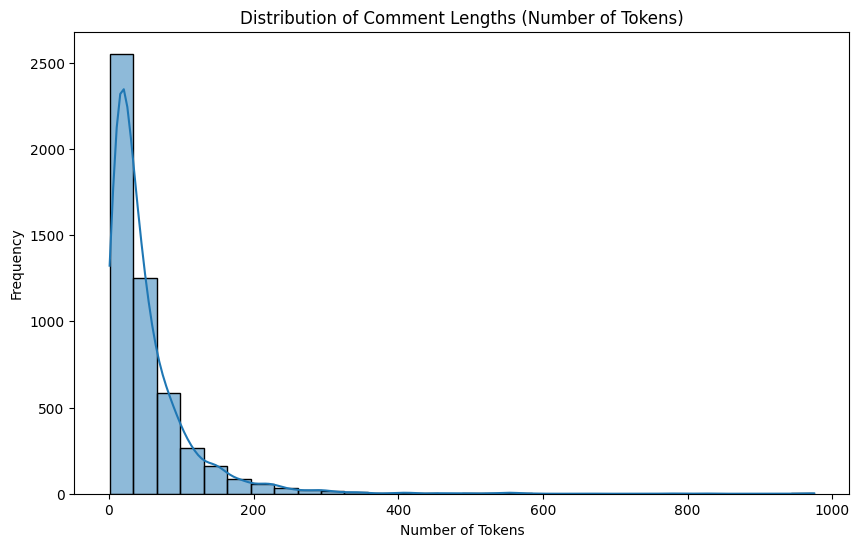

In [32]:
# Create a histogram of comment lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['token_count'], bins=30, kde=True)
plt.title('Distribution of Comment Lengths (Number of Tokens)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

In [33]:
# Function to calculate sentiment using TextBlob
def get_sentiment(text):
    if pd.isna(text) or text.strip() == "":
        return {'polarity': 0, 'subjectivity': 0}
    
    analysis = TextBlob(text)
    return {
        'polarity': analysis.sentiment.polarity,
        'subjectivity': analysis.sentiment.subjectivity
    }

# Categorize sentiment
def categorize_sentiment(polarity):
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

In [34]:
# Apply sentiment analysis to each comment
print("Performing sentiment analysis...")
sentiments = df['cleaned_text'].apply(get_sentiment)

# Extract polarity and subjectivity
df['polarity'] = sentiments.apply(lambda x: x['polarity'])
df['subjectivity'] = sentiments.apply(lambda x: x['subjectivity'])
df['sentiment_category'] = df['polarity'].apply(categorize_sentiment)

Performing sentiment analysis...


In [35]:
# Calculate sentiment statistics
sentiment_counts = df['sentiment_category'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_counts)
print(f"Positive: {sentiment_counts.get('positive', 0) / len(df) * 100:.2f}%")
print(f"Neutral: {sentiment_counts.get('neutral', 0) / len(df) * 100:.2f}%")
print(f"Negative: {sentiment_counts.get('negative', 0) / len(df) * 100:.2f}%")

print(f"\nAverage Polarity: {df['polarity'].mean():.4f}")
print(f"Average Subjectivity: {df['subjectivity'].mean():.4f}")


Sentiment Distribution:
sentiment_category
neutral     2410
positive    2009
negative     644
Name: count, dtype: int64
Positive: 39.68%
Neutral: 47.60%
Negative: 12.72%

Average Polarity: 0.0797
Average Subjectivity: 0.4378


In [36]:
# Save the sentiment analysis results
output_path = 'output/sentiment_results.csv'
df.to_csv(output_path, index=False)
print(f"\nSentiment analysis results saved to {output_path}")


Sentiment analysis results saved to output/sentiment_results.csv


In [37]:
# Display sample of results
print("\nSample of sentiment analysis results:")
sample_cols = ['author', 'cleaned_text', 'polarity', 'subjectivity', 'sentiment_category']
print(df[sample_cols].head())

# Find most positive and negative comments
most_positive = df.loc[df['polarity'].idxmax()]
most_negative = df.loc[df['polarity'].idxmin()]

print("\nMost positive comment:")
print(f"Author: {most_positive['author']}")
print(f"Comment: {most_positive['body']}")
print(f"Polarity: {most_positive['polarity']:.4f}")

print("\nMost negative comment:")
print(f"Author: {most_negative['author']}")
print(f"Comment: {most_negative['body']}")
print(f"Polarity: {most_negative['polarity']:.4f}")


Sample of sentiment analysis results:
           author                                       cleaned_text  \
4757    [deleted]  oh geez thats completely out of my price range...   
2086   Mastgoboom  wegovy is the same drug fda approved purely fo...   
3565  foxensfancy  i was on samples of a similar medication same ...   
2894    [deleted]  most doctors will recommend diet and exercise ...   
2893    [deleted]  i think the reason he recommended it is that i...   

      polarity  subjectivity sentiment_category  
4757  0.050000      0.262500            neutral  
2086  0.107143      0.312500           positive  
3565  0.049621      0.219697            neutral  
2894  0.271429      0.480952           positive  
2893  0.044231      0.405769            neutral  

Most positive comment:
Author: krampuskids
Comment: https://i.redd.it/jntkafp7olqc1.gif

thank you for the excellent info!
Polarity: 1.0000

Most negative comment:
Author: Kaitlynhod
Comment: That’s awful :(
Polarity: -1.0000


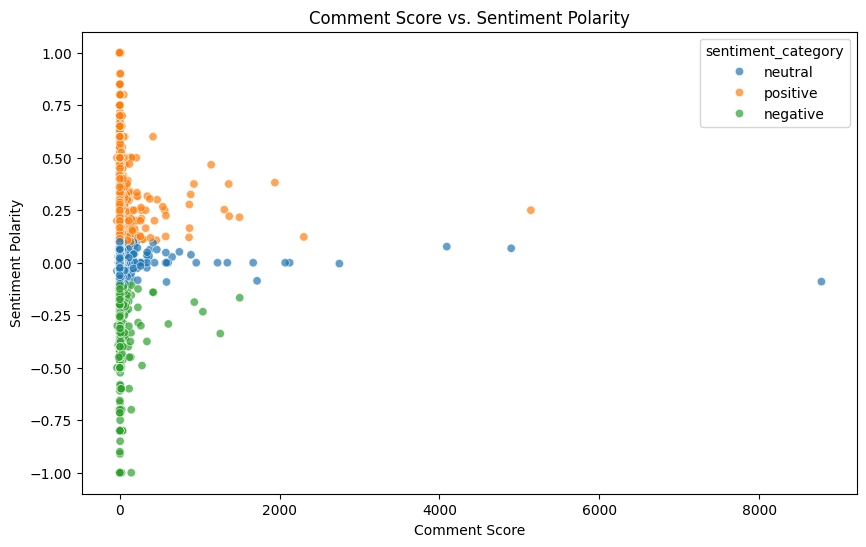

In [38]:
# Analyze sentiment by comment score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='score', y='polarity', hue='sentiment_category', alpha=0.7)
plt.title('Comment Score vs. Sentiment Polarity')
plt.xlabel('Comment Score')
plt.ylabel('Sentiment Polarity')
plt.show()

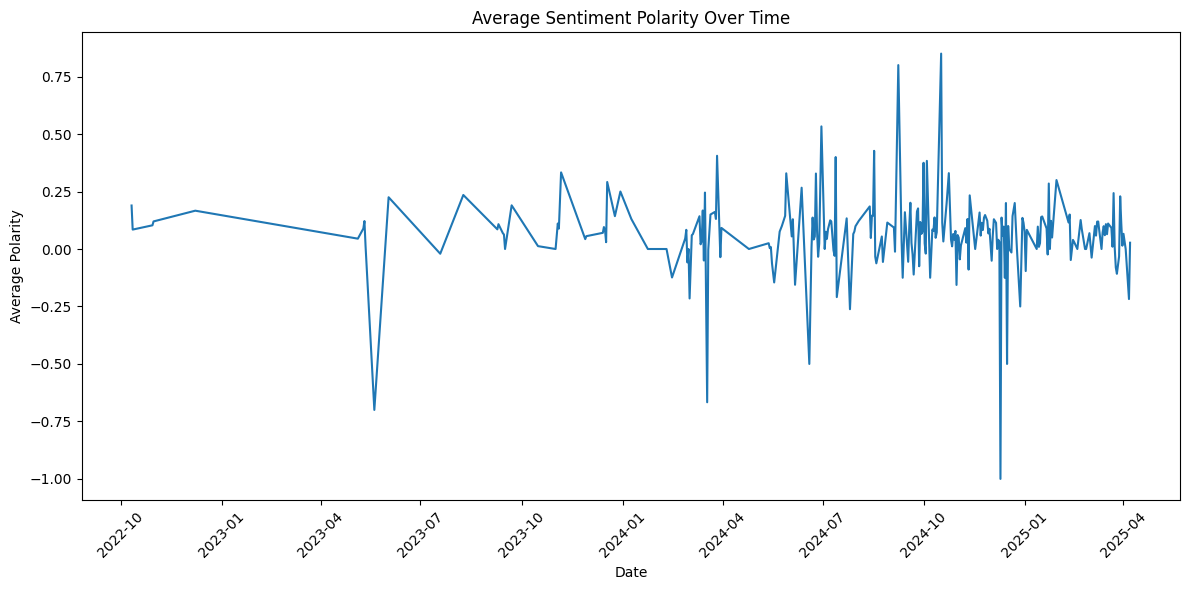

In [39]:
# Analyze sentiment over time
plt.figure(figsize=(12, 6))
df['date'] = pd.to_datetime(df['created_datetime']).dt.date
sentiment_by_date = df.groupby('date')['polarity'].mean().reset_index()
sns.lineplot(data=sentiment_by_date, x='date', y='polarity')
plt.title('Average Sentiment Polarity Over Time')
plt.xlabel('Date')
plt.ylabel('Average Polarity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

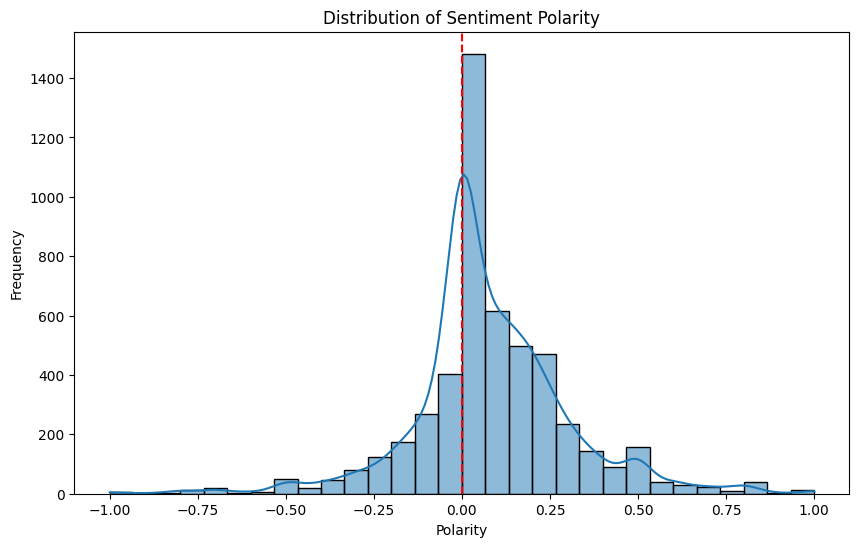

In [40]:
# Create sentiment distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df['polarity'], bins=30, kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.show()

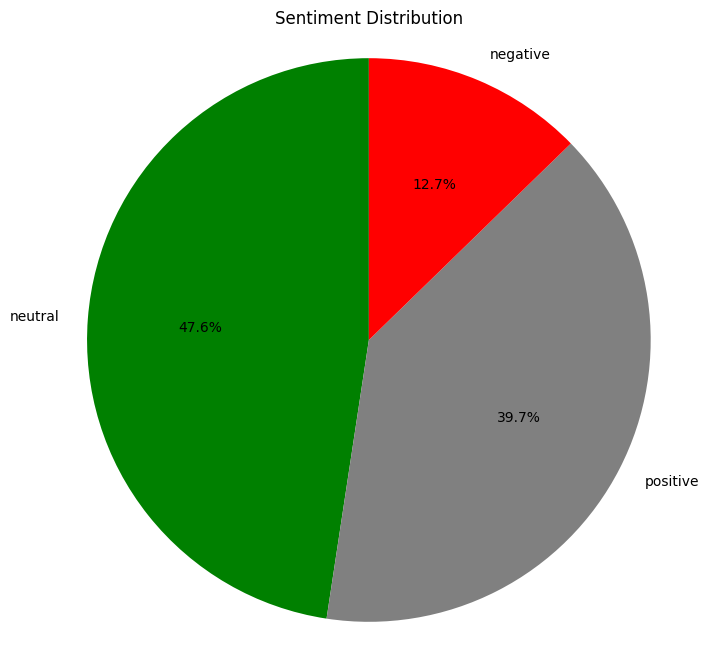


Sentiment analysis completed successfully!


In [41]:
# Create pie chart of sentiment categories
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['green', 'gray', 'red'])
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()
print("\nSentiment analysis completed successfully!")

In [42]:
# Function to create word cloud from text
def create_wordcloud(text, title, mask=None, background_color='white'):
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        max_words=200, 
        background_color=background_color,
        colormap='viridis',
        contour_width=1,
        contour_color='steelblue',
        mask=mask
    ).generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()

# Extract common words from each sentiment category
def get_common_words(text, n=20):
    words = re.findall(r'\b\w+\b', text.lower())
    # Filter out very short words
    words = [word for word in words if len(word) > 2]
    return Counter(words).most_common(n)

# Create bar charts for most common words in each sentiment category
def plot_common_words(common_words, title, color):
    words, counts = zip(*common_words)
    plt.figure(figsize=(12, 6))
    plt.bar(words, counts, color=color)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    plt.close()

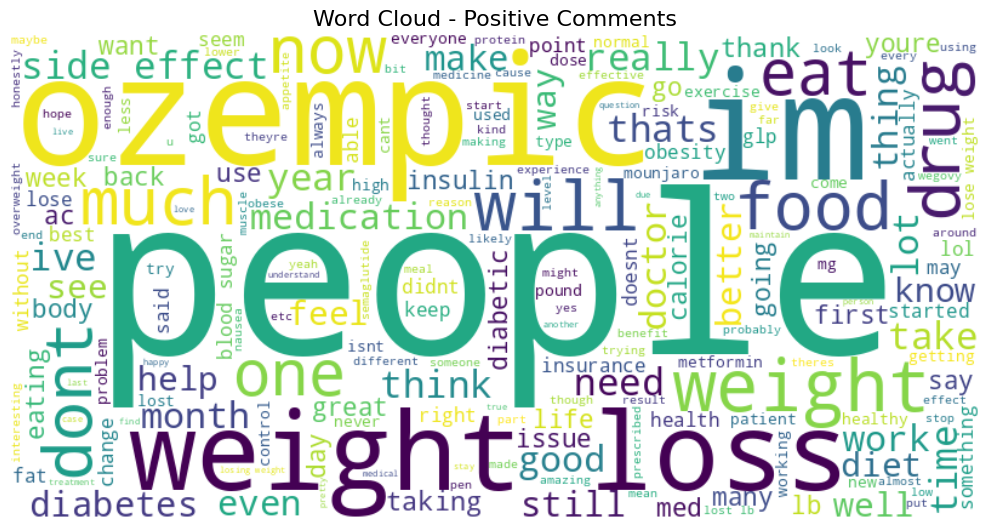

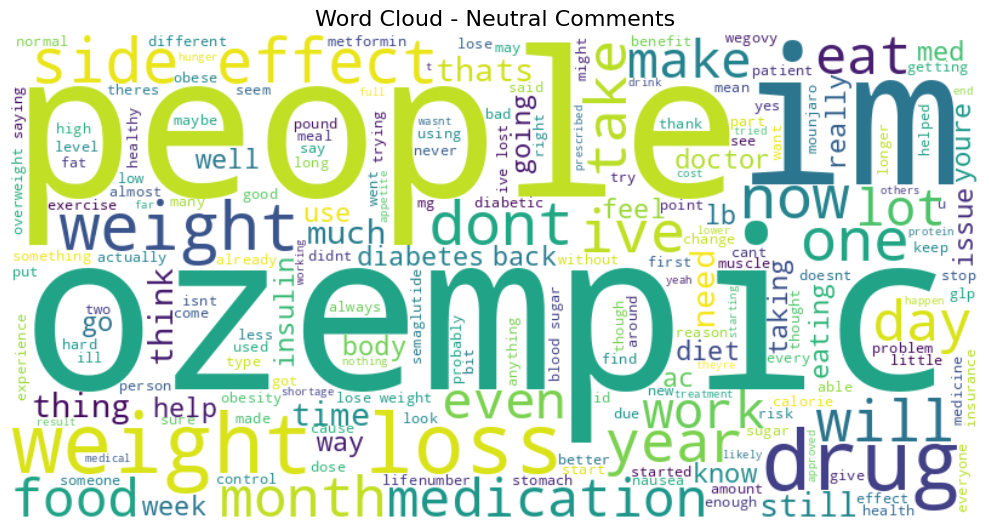

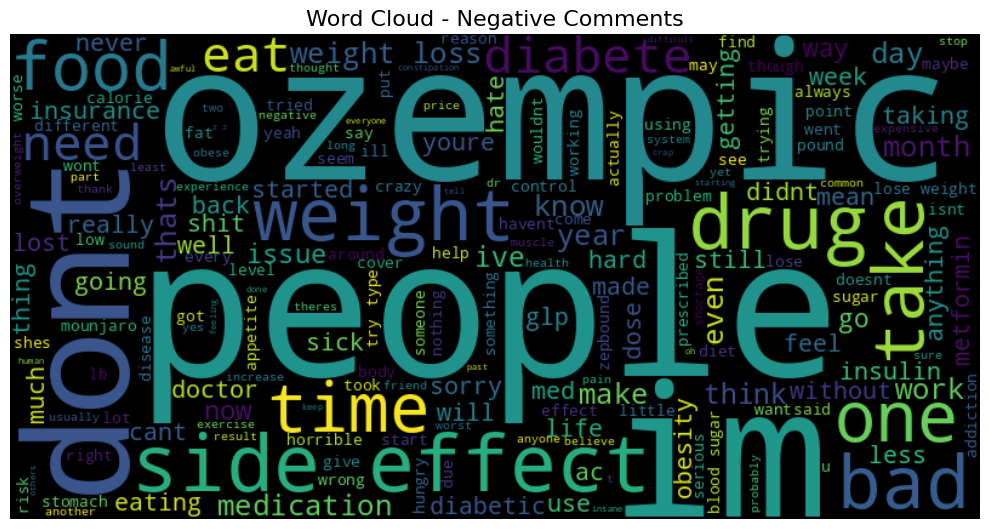

In [43]:

# Create word clouds for positive, neutral, and negative comments
positive_comments = ' '.join(df[df['sentiment_category'] == 'positive']['cleaned_text'])
neutral_comments = ' '.join(df[df['sentiment_category'] == 'neutral']['cleaned_text'])
negative_comments = ' '.join(df[df['sentiment_category'] == 'negative']['cleaned_text'])

create_wordcloud(positive_comments, 'Word Cloud - Positive Comments')
create_wordcloud(neutral_comments, 'Word Cloud - Neutral Comments')
create_wordcloud(negative_comments, 'Word Cloud - Negative Comments', background_color='black')

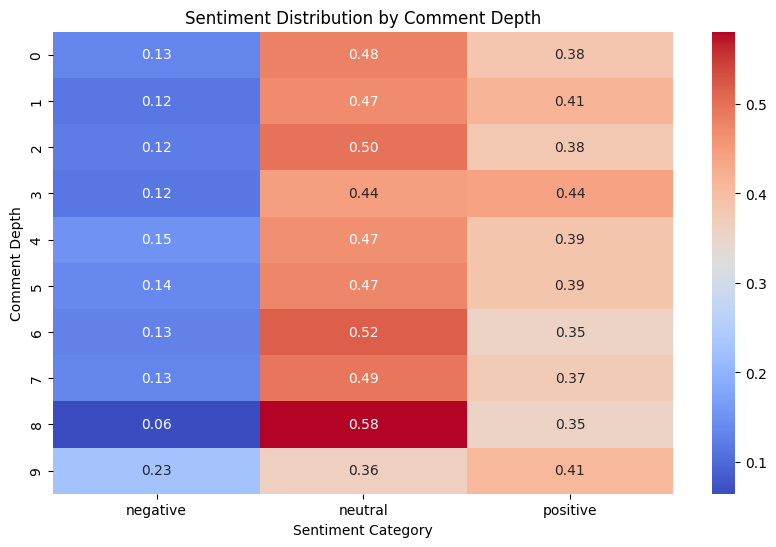

In [44]:

# Create a heatmap of sentiment by comment depth
plt.figure(figsize=(10, 6))
sentiment_depth = pd.crosstab(df['depth'], df['sentiment_category'])
sentiment_depth_pct = sentiment_depth.div(sentiment_depth.sum(axis=1), axis=0)
sns.heatmap(sentiment_depth_pct, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Sentiment Distribution by Comment Depth')
plt.xlabel('Sentiment Category')
plt.ylabel('Comment Depth')
plt.show()

/var/folders/j9/s32l889s16b4hz_8cwxhbgmc0000gn/T/ipykernel_63132/2863455489.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment_category', y='polarity', data=df, palette='viridis')


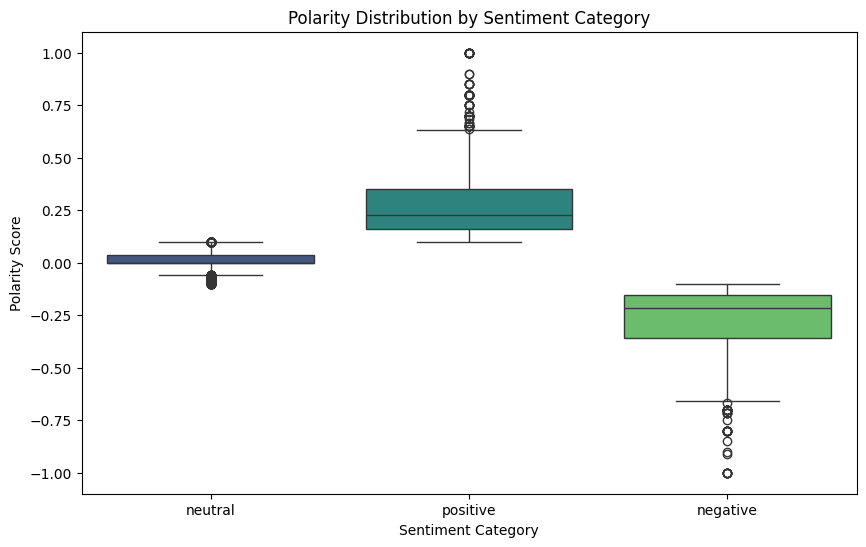

In [45]:
# Create a boxplot of polarity by sentiment category
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment_category', y='polarity', data=df, palette='viridis')
plt.title('Polarity Distribution by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Polarity Score')
plt.show()

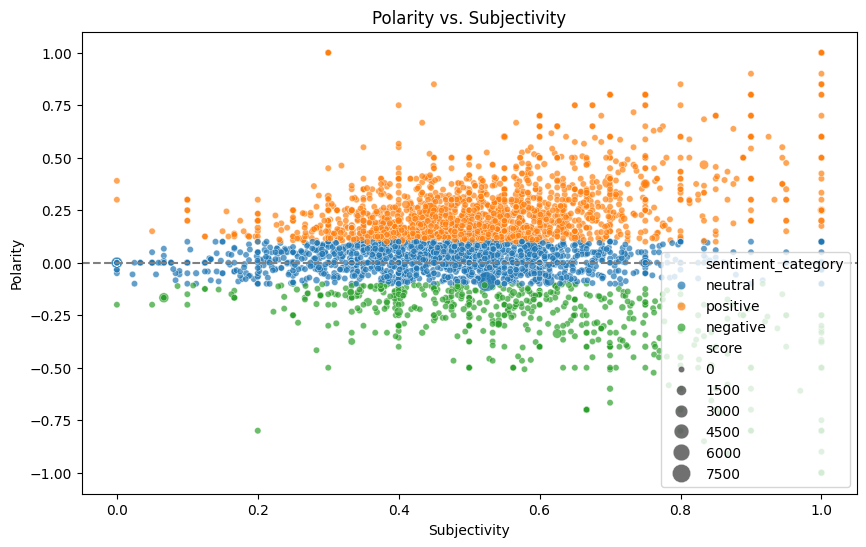

In [46]:
# Create a scatter plot of polarity vs. subjectivity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='subjectivity', y='polarity', hue='sentiment_category', size='score', sizes=(20, 200), alpha=0.7)
plt.title('Polarity vs. Subjectivity')
plt.xlabel('Subjectivity')
plt.ylabel('Polarity')
plt.axhline(y=0, color='gray', linestyle='--')
plt.show()

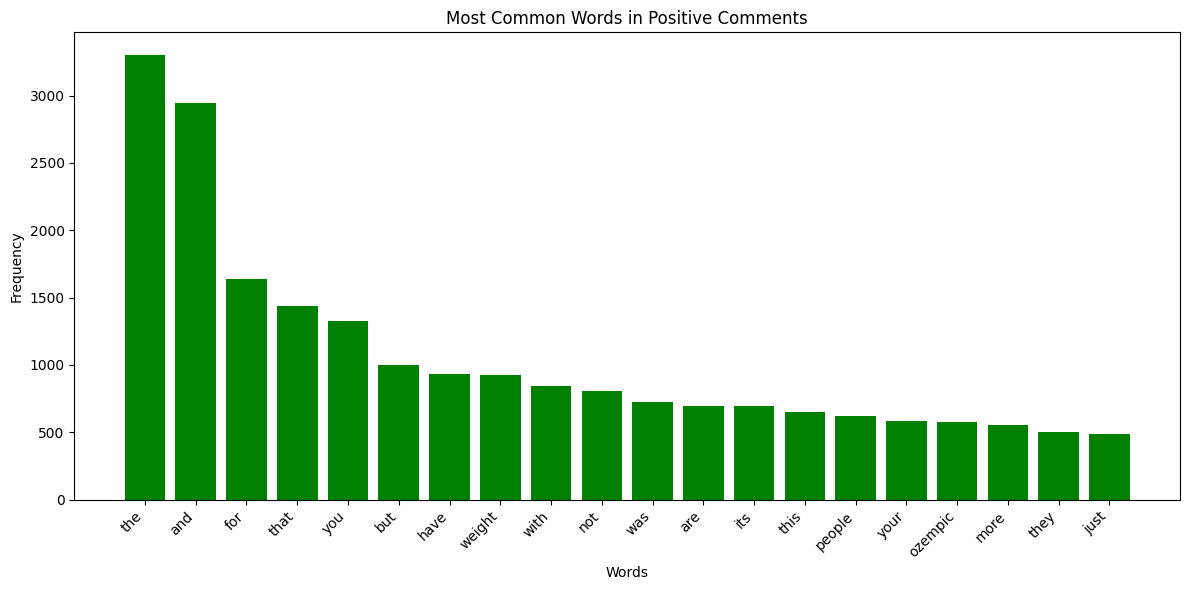

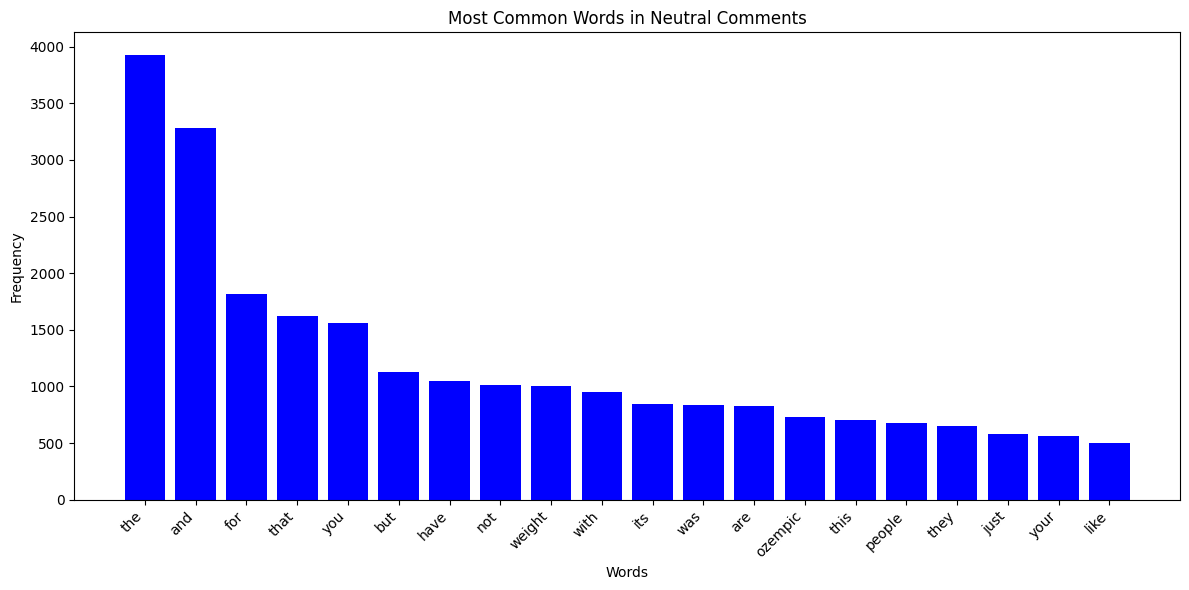

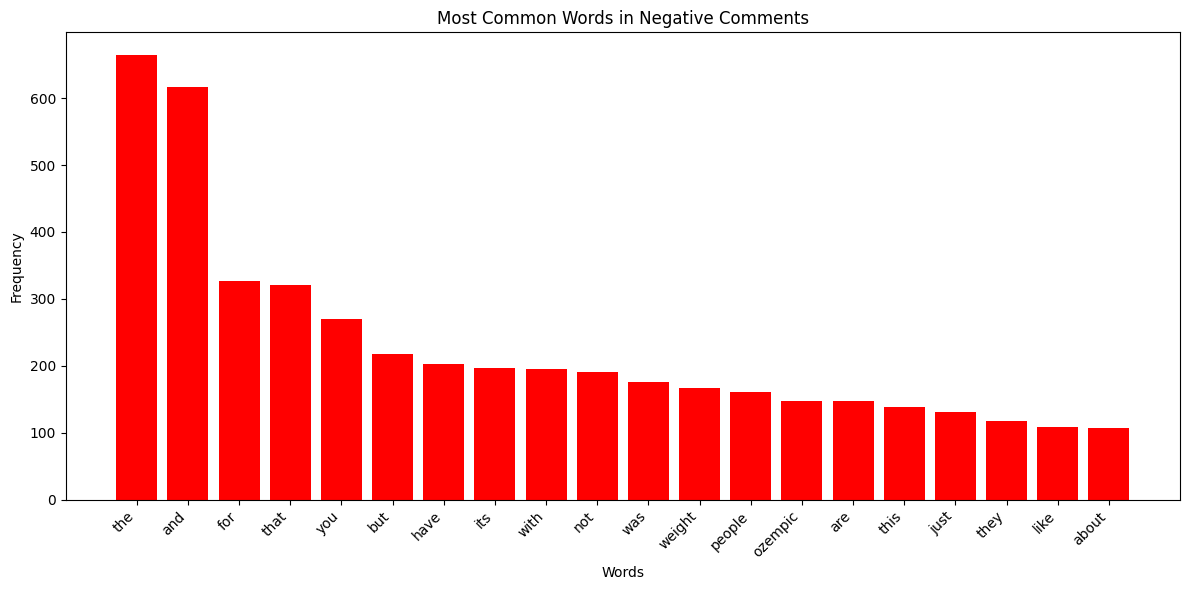

In [47]:
positive_common = get_common_words(positive_comments)
neutral_common = get_common_words(neutral_comments)
negative_common = get_common_words(negative_comments)

plot_common_words(positive_common, 'Most Common Words in Positive Comments', 'green')
plot_common_words(neutral_common, 'Most Common Words in Neutral Comments', 'blue')
plot_common_words(negative_common, 'Most Common Words in Negative Comments', 'red')

<Figure size 1200x600 with 0 Axes>

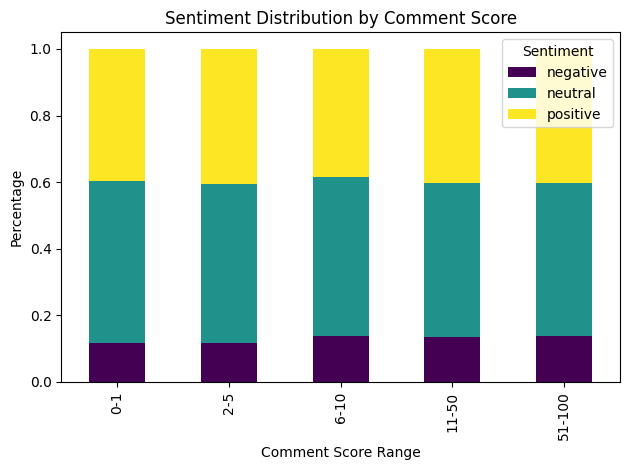


Visualization completed successfully!


In [48]:
# Create a stacked bar chart of sentiment categories by score ranges
df['score_range'] = pd.cut(df['score'], bins=[0, 1, 5, 10, 50, 100], labels=['0-1', '2-5', '6-10', '11-50', '51-100'])
sentiment_by_score = pd.crosstab(df['score_range'], df['sentiment_category'])
sentiment_by_score_pct = sentiment_by_score.div(sentiment_by_score.sum(axis=1), axis=0)

plt.figure(figsize=(12, 6))
sentiment_by_score_pct.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Sentiment Distribution by Comment Score')
plt.xlabel('Comment Score Range')
plt.ylabel('Percentage')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

print("\nVisualization completed successfully!")